<a href="https://colab.research.google.com/github/buisonanh/customer_segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prepare data**

In [109]:
import pandas as pd
import datetime as dt

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
# Load the transactional and items data
transactions_df = pd.read_csv("/content/drive/MyDrive/DA20 - Final Project/Unsupervised Learning/customer-transactions.csv")
items_df = pd.read_csv("/content/drive/MyDrive/DA20 - Final Project/Unsupervised Learning/items.csv")

print(transactions_df.head())
print(items_df.head())

   OrderID  CustomerID  ItemID TransactionDate   Channel
0        0           0     352      2020-03-21  In Store
1        0           0    3433      2020-07-14  In Store
2        0           0   11162      2020-08-09  In Store
3        0           0   13011      2020-12-07  In Store
4        0           0   13885      2020-11-08  In Store
   ItemID                     Product             Brand  SellPrice  CostPrice
0       1  032irview0.686128260621012  Ki)D3jDmA,RIP68X        943        359
1       2  070ttream0.518887735674677  GO4582ey<S!+k1VE        717        207
2       3  070htream0.333307794468401  G.Kb^jz*soY!(-4Q        739        199
3       4  100Grseys0.271522111052549  Dr|vm[-5p~56Y\mk        532        262
4       5  100[nside0.645837365801341  Dr|vm[-5p~56Y\mk        593        392


In [112]:
print(transactions_df.isnull().sum())
print()
print(items_df.isnull().sum())

OrderID            0
CustomerID         0
ItemID             0
TransactionDate    0
Channel            0
dtype: int64

ItemID       0
Product      0
Brand        0
SellPrice    0
CostPrice    0
dtype: int64


In [113]:
# Identify duplicate rows
print(f'Number of duplicates (transactions_df): {transactions_df.duplicated().sum()}')
print(f'Number of duplicates (items_df): {items_df.duplicated().sum()}')

Number of duplicates (transactions_df): 0
Number of duplicates (items_df): 0


In [114]:
# Perform a left join on the ItemID column to add the SellPrice column to the transactions_df
transactions_df = pd.merge(transactions_df, items_df[['ItemID', 'SellPrice']], on='ItemID', how='left')

# Print the updated transactions dataframe
print(transactions_df.head())


   OrderID  CustomerID  ItemID TransactionDate   Channel  SellPrice
0        0           0     352      2020-03-21  In Store        735
1        0           0    3433      2020-07-14  In Store        963
2        0           0   11162      2020-08-09  In Store        582
3        0           0   13011      2020-12-07  In Store        339
4        0           0   13885      2020-11-08  In Store       1369


In [115]:
print(transactions_df.info())
print()
print(items_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25213 entries, 0 to 25212
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   OrderID          25213 non-null  int64 
 1   CustomerID       25213 non-null  int64 
 2   ItemID           25213 non-null  int64 
 3   TransactionDate  25213 non-null  object
 4   Channel          25213 non-null  object
 5   SellPrice        25213 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.3+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17889 entries, 0 to 17888
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ItemID     17889 non-null  int64 
 1   Product    17889 non-null  object
 2   Brand      17889 non-null  object
 3   SellPrice  17889 non-null  int64 
 4   CostPrice  17889 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 698.9+ KB
None


# **Calculate RFM Score**

In [116]:
# Convert the TransactionDate column to a datetime object
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Calculate the Recency, Frequency, and Monetary values for each customer
recency_df = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency_df['Recency'] = (dt.datetime.today() - recency_df['TransactionDate']).dt.days
recency_df.drop('TransactionDate', axis=1, inplace=True)

frequency_df = transactions_df.groupby('CustomerID')['OrderID'].nunique().reset_index()
frequency_df.rename(columns={'OrderID': 'Frequency'}, inplace=True)

monetary_df = transactions_df.groupby('CustomerID')['SellPrice'].sum().reset_index()
monetary_df.rename(columns={'SellPrice': 'Monetary'}, inplace=True)

# Merge the Recency, Frequency, and Monetary dataframes
rfm_df = pd.merge(recency_df, frequency_df, on='CustomerID')
rfm_df = pd.merge(rfm_df, monetary_df, on='CustomerID')


rfm_df.drop(columns=['CustomerID'], inplace=True)

# Print the RFM dataframe
print(rfm_df.head())

   Recency  Frequency  Monetary
0      874         15     32997
1      882         14     34948
2      886          7     17879
3      877          6     14603
4      875         14     37029


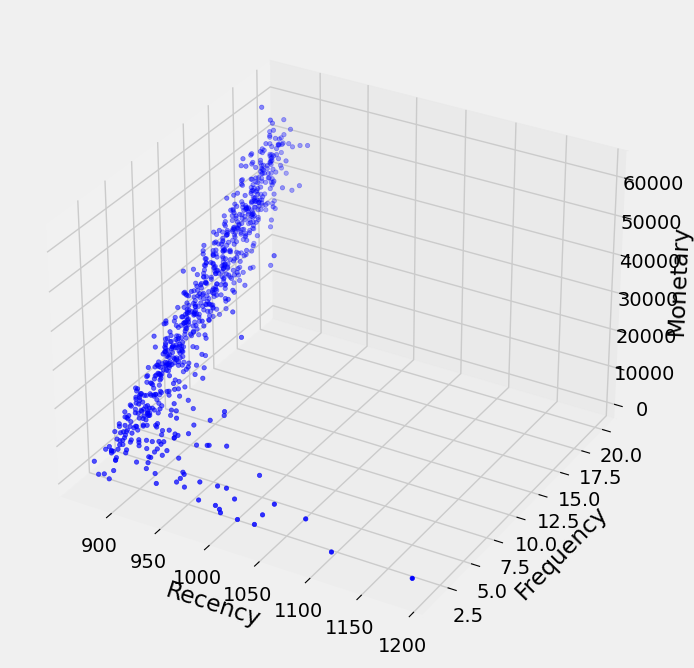

In [117]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

x = rfm_df['Recency']
y = rfm_df['Frequency']
z = rfm_df['Monetary']

ax.scatter(x, y, z, c='blue' ,s=10)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()


# **Scale Data**

In [118]:
X = rfm_df.iloc[:].values
X

array([[  874,    15, 32997],
       [  882,    14, 34948],
       [  886,     7, 17879],
       ...,
       [  871,    19, 45470],
       [  870,    15, 35462],
       [  875,    10, 24568]])

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
scaled_features

array([[-0.41645492,  0.79126817,  0.47966238],
       [-0.11620184,  0.60009261,  0.62405401],
       [ 0.0339247 , -0.73813626, -0.63920625],
       ...,
       [-0.52904983,  1.55597038,  1.4027771 ],
       [-0.56658146,  0.79126817,  0.66209465],
       [-0.37892329, -0.1646096 , -0.1441598 ]])

# **Evaluate**

In [120]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [121]:
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

**Sum of Squared Errors (SSE)**

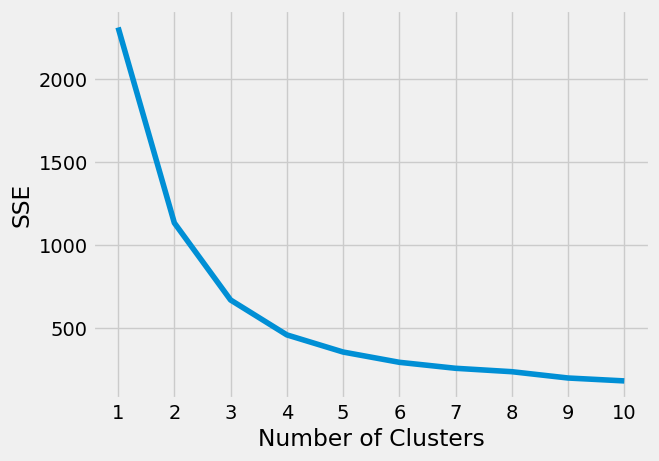

In [122]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
 kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
 kmeans.fit(scaled_features)
 sse.append(kmeans.inertia_)



plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [123]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

print(f'Elbow: {kl.elbow}')

Elbow: 3


**Sillhouette**

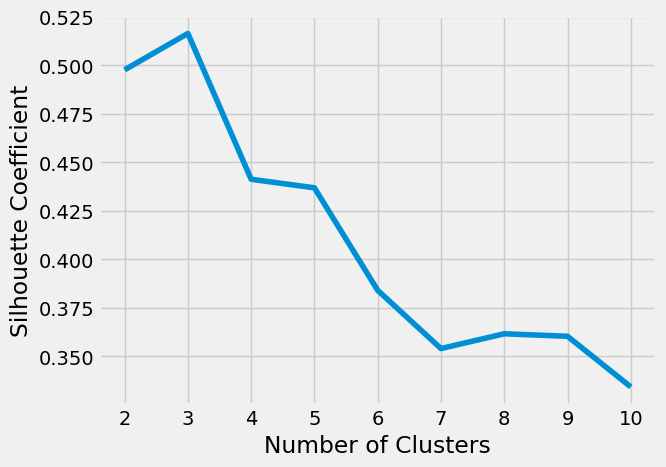

In [124]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
 kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
 kmeans.fit(scaled_features)
 score = silhouette_score(scaled_features, kmeans.labels_)
 silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [125]:
import numpy as np

# Find the index of the maximum silhouette score
best_idx = np.argmax(silhouette_coefficients)

# The best number of clusters is the index plus 2 (because we started at 2 clusters)
best_n_clusters = best_idx + 2

print(f"The best number of clusters is {best_n_clusters}")


The best number of clusters is 3


# **Model (K-Mean Clustering)**

### 3 clusters (The best)

In [126]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [127]:
import plotly.express as px

# Create a DataFrame with the RFM scores and cluster labels
df = pd.DataFrame(X, columns=['Recency', 'Frequency', 'Monetary'])
df['Cluster'] = y_kmeans
df['Cluster'] = df['Cluster'].astype('str')

# Create the plot
fig = px.scatter_3d(df, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', opacity=0.8, size_max=1, height=1000)

fig.show()



In [128]:
df

,Recency,Frequency,Monetary,Cluster
0,874,15,32997,0
1,882,14,34948,0
2,886,7,17879,2
3,877,6,14603,2
4,875,14,37029,0
...,...,...,...,...
765,892,13,29538,0
766,1043,2,5331,1
767,871,19,45470,0
768,870,15,35462,0


In [129]:
# Group the DataFrame by the 'Cluster' column
grouped = df.groupby('Cluster')

# Loop through each group and print the range of the 'Recency', 'Frequency', and 'Monetary' columns
for name, group in grouped:
    print(f"Range of cluster {int(name)+1}:")
    print(f"\tRecency: {group['Recency'].min()} -> {group['Recency'].max()}")
    print(f"\tFrequency: {group['Frequency'].min()} -> {group['Frequency'].max()}")
    print(f"\tMonetary: {group['Monetary'].min()} -> {group['Monetary'].max()}")
    print()

Range of cluster 1:
	Recency: 870 -> 934
	Frequency: 10 -> 20
	Monetary: 22110 -> 62539

Range of cluster 2:
	Recency: 934 -> 1187
	Frequency: 1 -> 6
	Monetary: 745 -> 16153

Range of cluster 3:
	Recency: 870 -> 940
	Frequency: 1 -> 12
	Monetary: 1296 -> 29255



In [130]:
"""
Rearranged:

Range of cluster green:
	Recency: 934 -> 1187
	Frequency: 1 -> 6
	Monetary: 745 -> 16153

Range of cluster orange:
	Recency: 870 -> 940
	Frequency: 1 -> 12
	Monetary: 1296 -> 29255

Range of cluster purple:
	Recency: 870 -> 934
	Frequency: 10 -> 20
	Monetary: 22110 -> 62539

"""

'\nRearranged:\n\nRange of cluster 1:\n\tRecency: 867 -> 1184\n\tFrequency: 1 -> 11\n\tMonetary: 745 -> 18951\n\nRange of cluster 2:\n\tRecency: 867 -> 937\n\tFrequency: 6 -> 17\n\tMonetary: 19109 -> 34628\n  \nRange of cluster 3:\n\tRecency: 867 -> 931\n\tFrequency: 10 -> 20\n\tMonetary: 34661 -> 62539\n'

### 4 clusters (Not the best)

In [131]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [132]:
import plotly.express as px

# Create a DataFrame with the RFM scores and cluster labels
df = pd.DataFrame(X, columns=['Recency', 'Frequency', 'Monetary'])
df['Cluster'] = y_kmeans
df['Cluster'] = df['Cluster'].astype('str')

# Create the plot
fig = px.scatter_3d(df, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', opacity=0.8, size_max=1, height=1000)

fig.show()



In [133]:
# Group the DataFrame by the 'Cluster' column
grouped = df.groupby('Cluster')

# Loop through each group and print the range of the 'Recency', 'Frequency', and 'Monetary' columns
for name, group in grouped:
    print(f"Range of cluster {int(name)+1}:")
    print(f"\tRecency: {group['Recency'].min()} -> {group['Recency'].max()}")
    print(f"\tFrequency: {group['Frequency'].min()} -> {group['Frequency'].max()}")
    print(f"\tMonetary: {group['Monetary'].min()} -> {group['Monetary'].max()}")
    print()

Range of cluster 1:
	Recency: 870 -> 901
	Frequency: 13 -> 20
	Monetary: 28302 -> 62539

Range of cluster 2:
	Recency: 870 -> 940
	Frequency: 1 -> 9
	Monetary: 1296 -> 25061

Range of cluster 3:
	Recency: 870 -> 934
	Frequency: 7 -> 16
	Monetary: 16388 -> 39366

Range of cluster 4:
	Recency: 944 -> 1187
	Frequency: 1 -> 6
	Monetary: 745 -> 16153

